In [1]:
# importing packages
import numpy as np
import pandas as pd
from scipy import stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import optimize
import time
import pickle

In [2]:
def F_o(t,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    if t < sd:
        
        p = F_b + p_0
        
    else:
        
        p = F_b + (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t-sd))/(b_m**2-b_p*b_m) + 
                   (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-sd)))
    
    return p

def F_s(t,t_l,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    p_t_l = (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t_l-sd))/(b_m**2-b_p*b_m) + 
             (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t_l-sd)))
    
    if t_l < sd:
        
        p = F_b + ((p_0-a/((b_p-b_m)*b_m*g))*np.exp(-b_p*(t-t_l)) + a*np.exp(-b_m*(t-t_l))/((b_p-b_m)*b_m*g))
    
    else:
        
        p = F_b + ((p_t_l + a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-t_l)) -
             a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m)*np.exp(-b_m*(t-t_l)))
        
    return p

def f(x,t,alpha,beta,gamma,sigma,k,mu,P_b,F_b,sd):
    
    background = P_b*stats.norm.pdf(x,np.log10(F_b),sigma)
    
    on = (1-P_b)*(1-stats.gamma.cdf(t,k,scale=mu/k))*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)),sigma)
    
    n = np.size(x)
    
    if n == 1:
        f_s = integrate.quad(lambda t_lag: 
                             stats.norm.pdf(x,np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                             *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    else:
        f_s = np.zeros(n)
        for i in np.arange(n):
            f_s[i] = integrate.quad(lambda t_lag: 
                                    stats.norm.pdf(x[i],np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                                    *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    
    silent = (1-P_b)*f_s
    
    F = on + background + silent
    
    return F

def error(params,data_t,data_x,nbins=100):
    
    # timepoints
    t = np.unique(data_t)

    # initializing error array
    err = []

    # iterating through each timepoint to calculate error

    for i in np.arange(np.size(t)):
        # getting all data at time t[i]
        data_x_sub = data_x[data_t == t[i]]

        # bin data and convert to pdf
        actual_pdf,bins = np.histogram(data_x_sub,bins=nbins,density=True)

        # calculate bin width
        w = np.mean(bins[1:]-bins[:-1])

        # calculate bin midpoints
        bin_midpoints = bins[:-1]+w/2

        # evaluating model f(x,t) (PDF for fluorescence over time) at midpoints
        model_pdf = f(bin_midpoints,t[i],*params)

        # calculating and appending error
        err = np.append(err, actual_pdf - model_pdf)
        
    return err

def error_Cit(p_C,data_t,data_x,sd=0,nbins=100):
    
    # putting Cit params in overall params array, setting gamma and k to 1
    params = [p_C[0],p_C[1],1,p_C[2],1,p_C[3],p_C[4],p_C[5],sd]
        
    return error(params,data_t,data_x,nbins=nbins)

def error_mCh(p_m,data_t,data_x,beta,sd=0,nbins=100):
    
    # putting mCh params in overall params array, fixing beta
    params = [p_m[0],beta,p_m[1],p_m[2],p_m[3],p_m[4],p_m[5],p_m[6],sd]
    
    return error(params,data_t,data_x,nbins=nbins)

def plotModelFit(cloneName, data_x, data_t, params, fluor, xlims, col=3):
    
    # setting color for fluorophore
    if fluor == 'Citrine':
        c = '#FFA900'
    elif fluor == 'mCherry':
        c = '#962A2F'
    else:
        c = 'gray'
    
    # timepoints
    t = np.unique(data_t)
    n = np.size(t)
    
    # creating figure
    rows = np.int(n/col) + (n%col>0)
    fig,ax = plt.subplots(rows,col,figsize=[12,6])

    # creating x vector
    x = np.linspace(xlims[0],xlims[1],100)

    # iterating through each timepoint and plotting data and model
    for i in np.arange(n):
        
        # calculating plot indicies
        k = np.int(i/col)
        j = np.int(i-k*col)
        
        # plotting model
        ax[k,j].plot(x,f(x,t[i],*params),lw=3)
        
        # plotting histogram of data
        data_x_sub = data_x[data_t == t[i]]
        ax[k,j].hist(data_x_sub,bins=100,range=xlims,density=True,color=c)
        
        # setting title as timepoint and removing tick labels
        ax[k,j].set_title('t = '+ np.str(t[i]),size='x-large')
        ax[k,j].set_xticklabels([])
        ax[k,j].set_yticklabels([])

    # formatting plot to axis labels don't overlap on plots
    plt.tight_layout()    

    # adding global title
    fig.suptitle(cloneName + ' Probabilistic Model Fit',size='xx-large')
    fig.subplots_adjust(top=0.88)

    # adding global xlabel
    fig.text(0.515,0,'Log ' + fluor + ' Fluorescence (AFU)',size='x-large',horizontalalignment='center')
    fig.subplots_adjust(bottom=0.05)

    # adding global ylabel
    fig.text(0,0.465,'Probability Denisty',size='x-large',rotation='vertical',verticalalignment='center')
    fig.subplots_adjust(left=0.03)
    
    # saving plot
    #plt.savefig(cloneName+'_'+fluor+'_ProbModelFit.png')
    
    # displaying plot
    plt.show()
    
def optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,5.5),saveAs='cellLine'):
    
    # initializing dictionaries
    CitFits = {}
    mChFits = {}
    
    # iterating through each clone
    for cloneName in cloneNames:
        
        # loading the data for the clone
        data = pd.read_csv(cloneName+'.csv',header=None)
    
        # converting from data frame to array
        data = data.values
        data_t = data[:,2]
        data_C = data[:,0]
        data_m = data[:,1]
        
        # optimizing Citrine parameters
        p = optimize.least_squares(error_Cit, i_C, bounds=b_C, args=(data_t,data_C))
        params = [p.x[0],p.x[1],1,p.x[2],1,p.x[3],p.x[4],p.x[5],0]
        print(params)
        
        # plotting model versus data for Citrine
        plotModelFit(cloneName,data_C,data_t,params,fluor='Citrine',xlims=xlim_C)
        
        # saving params in Citrine dict
        CitFits[cloneName] = params
        beta = params[1]
        sd = params[5]
        
        # optimizing mCherry parameters
        p = optimize.least_squares(error_mCh, i_m, bounds=b_m, args=(data_t,data_m,beta,sd))
        params = [p.x[0],beta,p.x[1],p.x[2],p.x[3],p.x[4],p.x[5],p.x[6],sd]
        print(params)
        
        # plotting model versus data for Citrine
        plotModelFit(cloneName,data_m,data_t,params,fluor='mCherry',xlims=xlim_m)
        
        # saving params in mCherry dict
        mChFits[cloneName] = params
        
    # saving the dictionaries
    with open(saveAs + '.pkl', 'wb') as f:
        pickle.dump((CitFits, mChFits), f)

### K562 HDAC 5kb Fits

In [3]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05     
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,F_b]

b_C = ([10000,  0.5, 0.1, 0, 0,    10],\
       [500000, 2.0, 0.4, 1, 0.25, 5000])

# setting inital guesses and bounds for mCherry
alpha = 460000   
gamma = 2
sigma = 0.30 
k = 5          
mu = 5       
P_b = 0.10     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([10000,   1,  0.2, 1,  0, 0,    10],\
       [10000000, 8, 0.5, 15, 20, 0.25, 5000])

[193039.61628972925, 0.6185585273383707, 1, 0.26332285036175, 1, 0.08148576039477842, 3.2651614031127978e-21, 1520.6549461016727, 0]


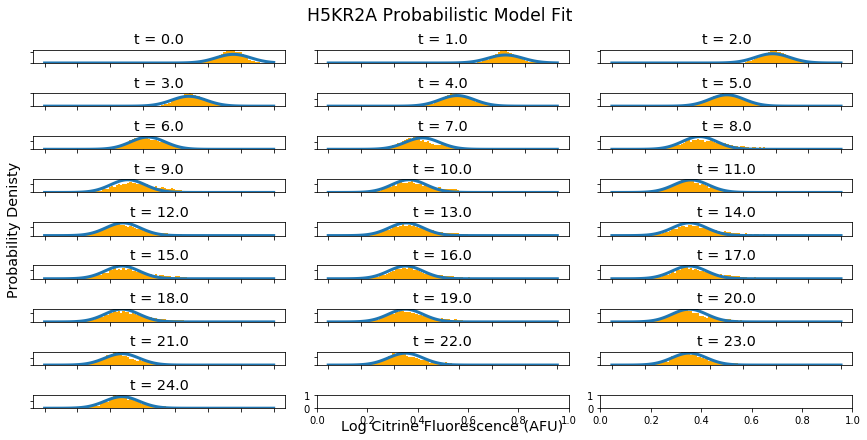

KeyboardInterrupt: 

In [4]:
start = time.time()

cloneNames = ['H5KR2A','H5KR3A']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,7),saveAs='K562_H5K_mRNAsd_Fits')

end = time.time()
print(end-start)

In [12]:
np.mean([1.28971673,1.07157041])

1.18064357

### CHO HDAC 1.2kb Fits

In [6]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05     
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,F_b]

b_C = ([10000,  0.7, 0.1, 0.001, 0,    100],\
       [1000000, 2.0, 0.4, 1,   0.25, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.2, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.


[248265.9499546256, 1.072494248468056, 1, 0.19912350336819398, 1, 0.0010000000000000002, 0.1840659858684322, 426.7176521291832, 0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.


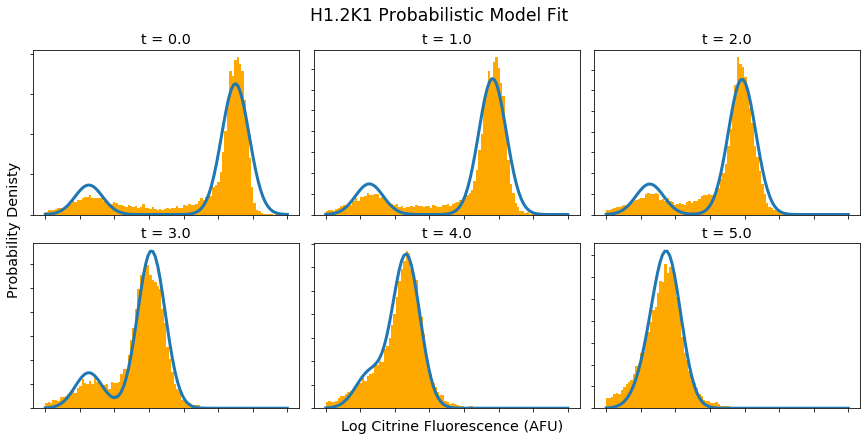

[49235.431290295695, 1.072494248468056, 9.056171253787111, 0.2668548935339435, 1.0526645450829988, 1.6170837379607872, 0.4089973477308531, 595.6284439970611, 0.0010000000000000002]


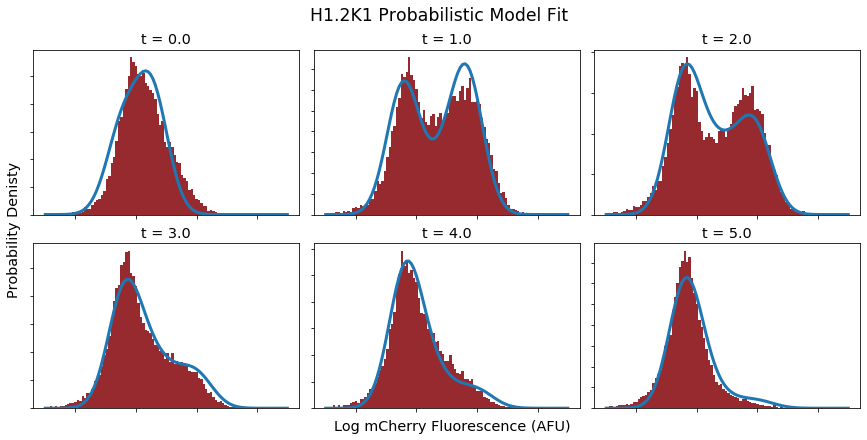

[234748.23274138887, 0.9560903887567814, 1, 0.20122161204170136, 1, 0.09684414799560499, 0.13446376545691072, 380.97642172595675, 0]


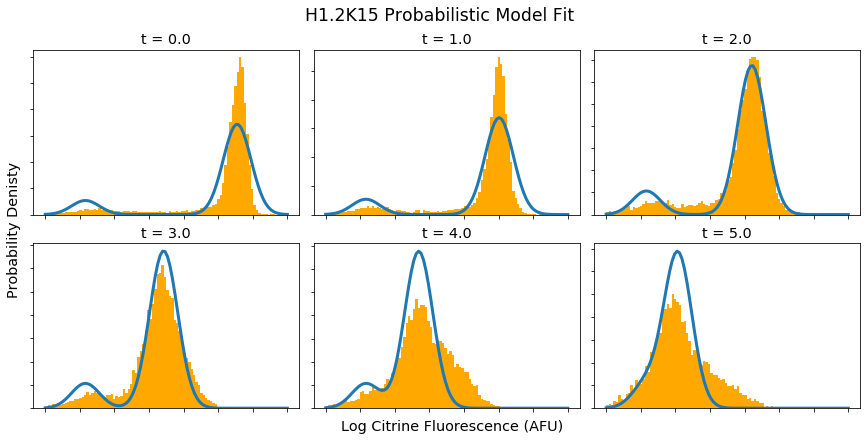

[61492.57607111664, 0.9560903887567814, 8.346776799176236, 0.28353129673438454, 1.870807408635942, 3.354167637223395, 0.33927683974249284, 947.5582562775797, 0.09684414799560499]


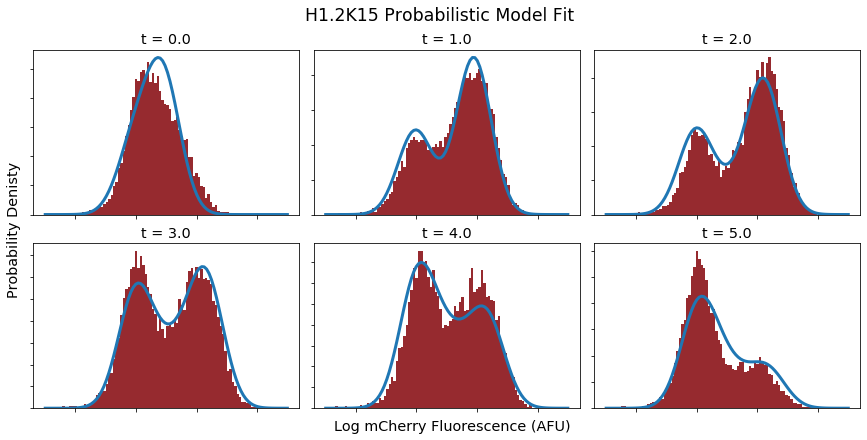

[261170.77406993788, 1.0596508512482459, 1, 0.1796700851780919, 1, 0.0010000000000000284, 0.11183604900054939, 492.754366785709, 0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.


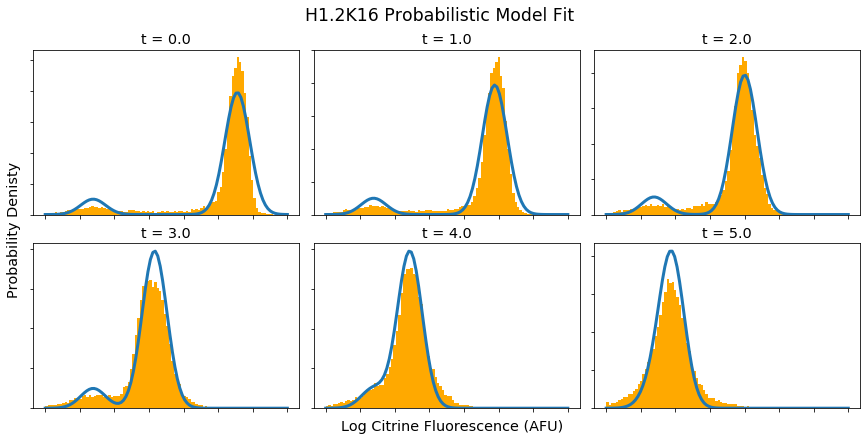

[52242.66757048084, 1.0596508512482459, 8.278649806675485, 0.27218350985122985, 2.1091965023782127, 1.9945029693632694, 0.3117877919975483, 672.323047905447, 0.0010000000000000284]


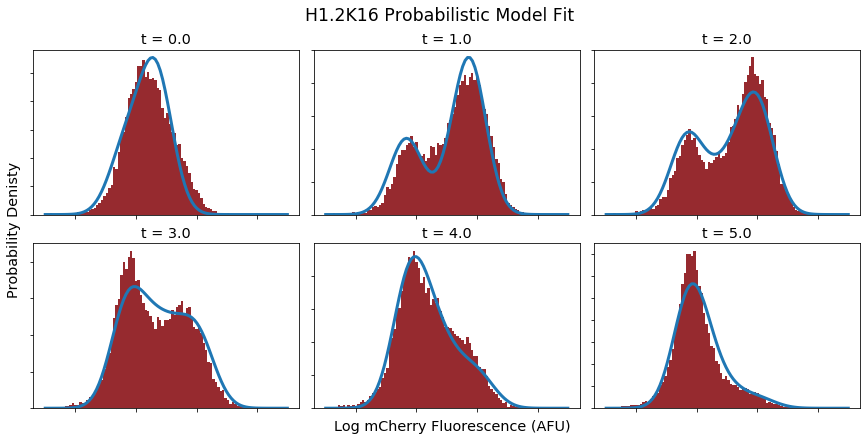

8882.555638551712


In [7]:
start = time.time()

cloneNames = ['H1.2K1','H1.2K15','H1.2K16']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,5.5),saveAs='CHO_H1.2K_Final_Fits')

end = time.time()
print(end-start)

In [10]:
np.mean([9.056171253787111,8.346776799176236,8.278649806675485])

8.560532619879611

### CHO HDAC4 Ins (MC)

In [8]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05     
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,F_b]

b_C = ([10000,  0.7, 0.1, 0, 0,    100],\
       [1000000, 2.0, 0.4, 1,   0.25, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 1  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.10     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.2, 1,  0, 0,    100],\
       [1000000, 15, 0.5, 15, 5, 0.5, 5000])

[427723.1706037757, 1.095156671194206, 1, 0.1530961348587255, 1, 0.3703154029315882, 0.06856115343890215, 287.3507362409701, 0]


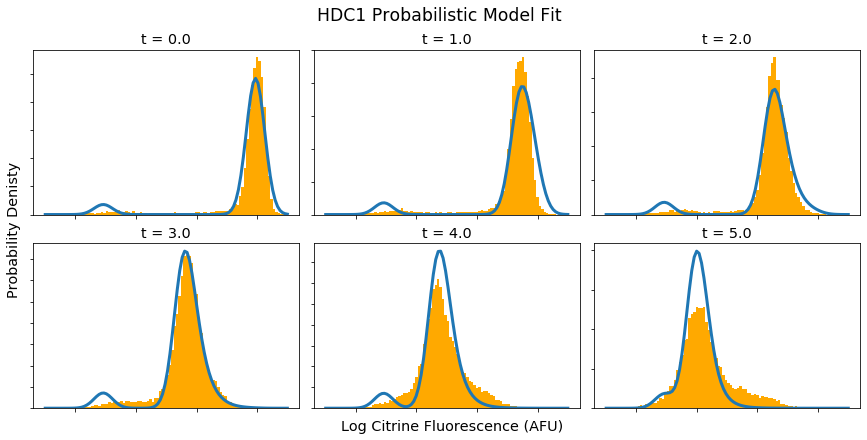

[93423.44453601324, 1.095156671194206, 2.300395343448281, 0.30707595809746513, 1.0000000000000002, 2.419561002844409, 0.1328215930446452, 643.763443442144, 0.3703154029315882]


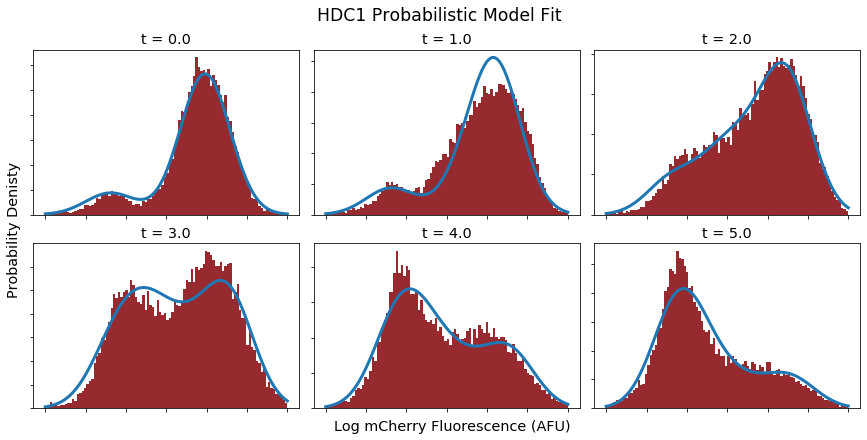

[401376.6216065876, 1.03348587607779, 1, 0.15271797419092514, 1, 0.482549212856143, 0.06961808738555729, 251.1640524535515, 0]


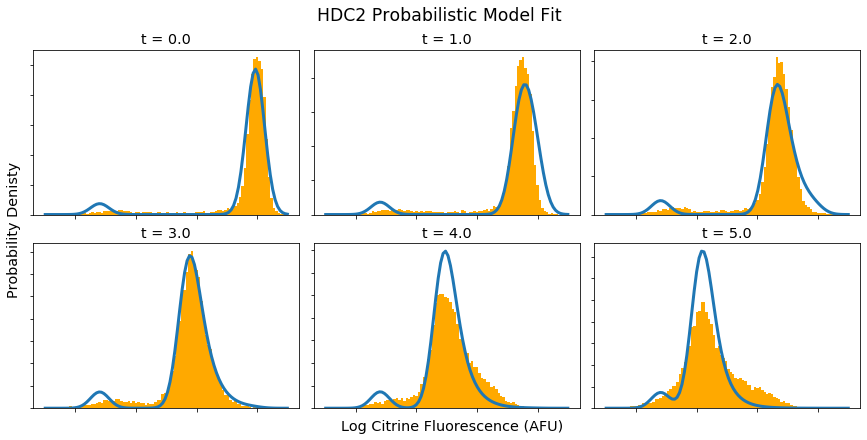

[86440.03692377867, 1.03348587607779, 2.638340461894902, 0.3211477030460389, 1.023539598871932, 2.978720166277007, 0.14978156980247243, 620.7661323578891, 0.482549212856143]


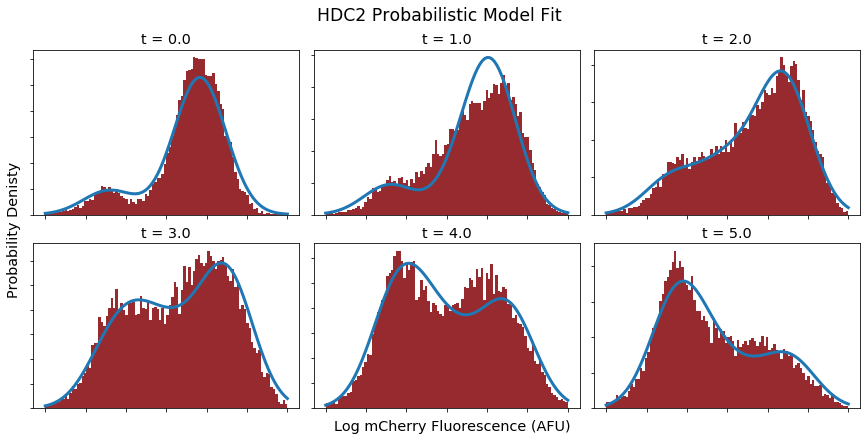

[398616.33723754797, 1.045688427464938, 1, 0.16207792751199027, 1, 0.38324368953242943, 0.0992447978994344, 348.48444096456876, 0]


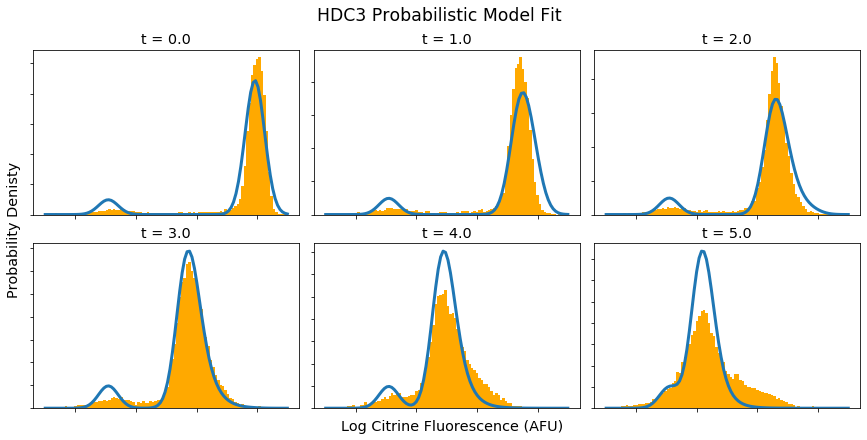

[67782.54857358467, 1.045688427464938, 1.7926287157711194, 0.31069556435665635, 1.0000000000000002, 3.321075946893539, 0.17259064877279406, 632.2476917071873, 0.38324368953242943]


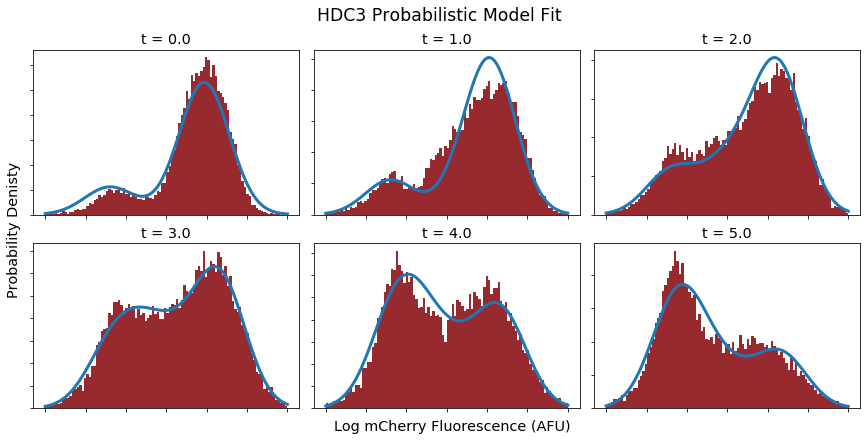

9654.557311296463


In [9]:
start = time.time()

cloneNames = ['HDC1','HDC2','HDC3']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDC_MC_Final_Fits')

end = time.time()
print(end-start)

In [11]:
np.mean([2.300395343448281,2.638340461894902,1.7926287157711194])

2.2437881737047674